In [1]:
!echo "Last updated:" `date`

Last updated: Tue Jul 21 12:33:36 PDT 2020


# Fitting regular GP in STAN

This notebook demonstrates how a GP is specified and sampled from in STAN.

In [2]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../util')
from pystan_vb_extract import pystan_vb_extract
import copy
from scipy.spatial import distance_matrix

In [3]:
# See for an explaination of the parameters (rho, alpha) and the convariance function used.
# https://mc-stan.org/docs/2_19/stan-users-guide/gaussian-process-regression.html
gp_model_code = """
data {
    int D;               // number of features (dimensions of X)
    int N;               // number of observations
    vector[N] y;         // response
    matrix[N, D] X;      // predictors
    real<lower=0> eps;   // amount to add to diagonal of covariance function (for numerical stability)
    
    // hyperparameters for GP covariance function range and scale.
    real m_rho;
    real<lower=0> s_rho;
    real m_alpha;
    real<lower=0> s_alpha;
}

parameters {
    real<lower=0> rho;   // range parameter in GP covariance fn
    real<lower=0> alpha; // covariance scale parameter in GP covariance fn
}

model {
    matrix[N, N] K;   // GP covariance matrix
    matrix[N, N] LK;  // cholesky of GP covariance matrix

    rho ~ lognormal(m_rho, s_rho);  // GP covariance function range parameter
    alpha ~ lognormal(m_alpha, s_alpha);  // GP covariance function scale parameter
   
    // Using exponential quadratic covariance function
    // K(d) = alpha^2 * exp(-d^2 / (2*rho))
    K = cov_exp_quad(to_array_1d(X), alpha, rho); 
    
    // Add small values along diagonal elements for numerical stability.
    for (n in 1:N) {
        K[n, n] = K[n, n] + eps;
    }
        
    LK = cholesky_decompose(K);

    // GP likelihood.
    y ~ multi_normal_cholesky(rep_vector(0.0, N), LK);
}
"""

In [4]:
%%time
sm = pystan.StanModel(model_code=gp_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dffb74429729d18e54b43f82d0570611 NOW.


CPU times: user 858 ms, sys: 66.2 ms, total: 924 ms
Wall time: 53.4 s


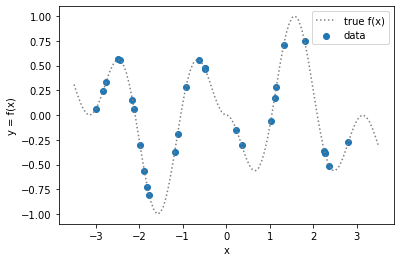

In [49]:
# Generate data.
np.random.seed(1)
def f(x):
    return np.sin(3 * x) * np.sin(x) * (-1)**(x > 0)
N = 30
# x = np.random.beta(.3, .3, N) * 6 - 3
x = np.random.rand(N) * 6 - 3
y = f(x)
plt.scatter(x, y, label='data')
plt.xlabel('x')
plt.ylabel('y = f(x)');

x_ = np.linspace(-3.5, 3.5, 100)
plt.plot(x_, f(x_), ls=':', c='grey', label='true f(x)')
plt.legend();

In [50]:
# Data dictionary.
data = dict(y=y, X=x.reshape(N, 1), N=N, D=1, eps=1e-6, m_rho=-2, s_rho=0.1, m_alpha=0, s_alpha=1)

In [51]:
%%time
# Fit via ADVI
vb_fit = sm.vb(data=data, iter=1000, seed=2)
vb_samples = pystan_vb_extract(vb_fit)

CPU times: user 123 ms, sys: 553 µs, total: 124 ms
Wall time: 122 ms


In [52]:
# %%time
# # Fit via HMC
# hmc_fit = sm.sampling(data=data, iter=1000, chains=1, warmup=500, thin=1,
#                       seed=1, algorithm='HMC', control=dict(stepsize=0.01, int_time=1))

In [53]:
def cov_fn(d, rho, alpha):
    return alpha ** 2 * np.exp(-0.5 * (d / rho) ** 2)
    
def gp_predict_maker(y, x, x_new):
    N = x.shape[0]
    N_new = x_new.shape[0]
    M = N + N_new
    xx = np.concatenate((x_new, x)).reshape(M, 1)
    D = distance_matrix(xx, xx)
    
    def gp_predict(rho, alpha, eps):
        K = cov_fn(D, rho, alpha) + np.eye(M) * eps
        K_new_old = K[:N_new, N_new:]
        K_old_inv = np.linalg.inv(K[N_new:, N_new:])
        C = K_new_old.dot(K_old_inv)
        mu = C.dot(y)
        S = K[:N_new, :N_new] - C.dot(K_new_old.T)
        return np.random.multivariate_normal(mu, S)
    
    return gp_predict

In [54]:
# samples = hmc_fit
samples = vb_samples

x_min = np.min(x) - 1
x_max = np.max(x) + 1
x_new = np.linspace(x_min, x_max, 50)
x_new = np.sort(np.concatenate((x_new, x)))
gp_predict = gp_predict_maker(y, x, x_new)

nsamples = len(samples['alpha'])
preds = np.stack([gp_predict(alpha=samples['alpha'][b],
                             rho=samples['rho'][b],
                             eps=data['eps'])
                  for b in range(nsamples)])

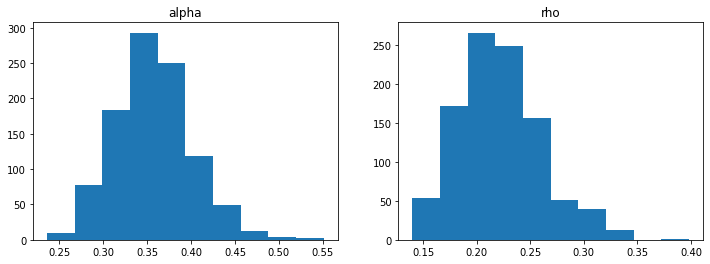

In [55]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(samples['alpha'])
plt.title('alpha')
plt.subplot(1, 2, 2)
plt.hist(samples['rho'])
plt.title('rho');

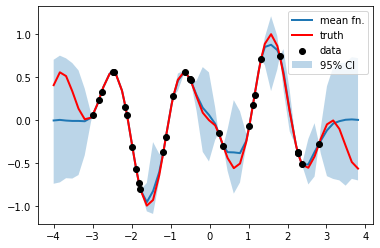

In [56]:
preds_mean = preds.mean(0)
preds_lower = np.percentile(preds, 2.5, axis=0)
preds_upper = np.percentile(preds, 97.5, axis=0)
plt.scatter(x, y, c='black', zorder=3, label='data')
plt.fill_between(x_new, preds_upper, preds_lower, alpha=.3, label='95% CI');
plt.plot(x_new, preds.mean(0), lw=2, label="mean fn.")
plt.plot(x_new, f(x_new), label="truth", lw=2, c='red')
plt.legend();